# Analysis of computer games for the store "Strimchik"

Research customer: Strimchik online store that sells computer games all over the world.

Input: Historical game sales data, user and expert ratings, genres and platforms (such as Xbox or PlayStation) are available from public sources. Data available for 2016, company plan for 2017

The purpose of the study: to identify patterns that determine the success of the game, make a recommendation for a potentially popular product and plan advertising campaigns.

Note: In the data set, the abbreviation ESRB (Entertainment Software Rating Board) comes across - this is an association that determines the age rating of computer games. The ESRB evaluates game content and assigns it to an appropriate age rating, such as Mature, Toddler, or Teen.

Sample work plan:
1. Acquaintance with the available data.
2. Data preprocessing.
3. Exploratory data analysis.
4. Portrait of a user from each region.
5. Hypothesis testing.
6. Conclusions.

## Data Acquaintance

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
data = pd.read_csv('/datasets/games.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [3]:
data

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [4]:
print(data.columns)

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')


### Conclusion after reviewing the data
1. The names of the columns must be brought to a single register.
2. Convert the following columns to the required data types:
Year_of_Release (float -> int)
Critic_Score (float -> int) data does not show values after zero
User_Score (string -> float)
3. It may be necessary to allocate separate dictionaries for platforms, rating and genre.
4. Identify duplicates.
5. The value of tbd in User_Score. Most likely it means to be done, i.e. we can assume that in these lines we do not have user rating data
6. There are games with almost zero sales, you need to check it out.

## Data preprocessing

In [5]:
data.columns = [column.lower() for column in data.columns]
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [6]:
data.drop(data[data['year_of_release'].isna()].index,inplace=True)
data['year_of_release'] = pd.to_numeric(data['year_of_release'], downcast='integer')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  int16  
 3   genre            16444 non-null  object 
 4   na_sales         16446 non-null  float64
 5   eu_sales         16446 non-null  float64
 6   jp_sales         16446 non-null  float64
 7   other_sales      16446 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(5), int16(1), object(5)
memory usage: 1.4+ MB


### Note
Before casting to int, the gaps must be filled in. But there is a problem that the later the game is released, the more missing values. Which may be due to the fact that the game is not popular, or because it is too new and has not yet had time to get a rating or other reasons.

To fill in the gaps in the rating, let's take the filtered median for two parameters - genre and platform, to be more accurate. An additional column will indicate whether the data has been changed or is the original.

In [7]:
data['critic_score'] = pd.to_numeric(data['critic_score'], downcast='integer')
data['user_score'] = pd.to_numeric(data['user_score'], downcast='float', errors ='coerce')
data['user_score'] = data['user_score'].round(1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  int16  
 3   genre            16444 non-null  object 
 4   na_sales         16446 non-null  float64
 5   eu_sales         16446 non-null  float64
 6   jp_sales         16446 non-null  float64
 7   other_sales      16446 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float32
 10  rating           9768 non-null   object 
dtypes: float32(1), float64(5), int16(1), object(4)
memory usage: 1.3+ MB


In [8]:
data['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [9]:
data['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

In [10]:
data[data['genre'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [11]:
data.dropna(subset=['genre'], inplace=True)

In [12]:
genre_list = data['genre'].unique()
genre_dict = {}
for genre in genre_list:
    print('Популярные оценки для жанра ', genre)
    rating_value_counts = data[data['genre'] == genre]['rating'].value_counts()
    print(rating_value_counts)
    genre_dict[genre] = rating_value_counts.index[0]
    
genre_dict

Популярные оценки для жанра  Sports
E       1162
T        195
E10+     105
M         16
Name: rating, dtype: int64
Популярные оценки для жанра  Platform
E       354
E10+    141
T        63
M         3
Name: rating, dtype: int64
Популярные оценки для жанра  Racing
E       576
T       167
E10+     95
M        18
Name: rating, dtype: int64
Популярные оценки для жанра  Role-Playing
T       415
M       161
E10+    111
E        83
Name: rating, dtype: int64
Популярные оценки для жанра  Puzzle
E       284
E10+     42
T        10
Name: rating, dtype: int64
Популярные оценки для жанра  Misc
E       449
T       228
E10+    166
M        13
EC        5
K-A       1
Name: rating, dtype: int64
Популярные оценки для жанра  Shooter
M       553
T       340
E10+     56
E        47
Name: rating, dtype: int64
Популярные оценки для жанра  Simulation
E       321
T       186
E10+     47
M         5
Name: rating, dtype: int64
Популярные оценки для жанра  Action
T       670
M       596
E10+    468
E       410
E

{'Sports': 'E',
 'Platform': 'E',
 'Racing': 'E',
 'Role-Playing': 'T',
 'Puzzle': 'E',
 'Misc': 'E',
 'Shooter': 'M',
 'Simulation': 'E',
 'Action': 'T',
 'Fighting': 'T',
 'Adventure': 'E',
 'Strategy': 'T'}

In [13]:
data['rating'] = data['rating'].fillna('NR')

def fill_rating(row):
    if row[10] == 'NR':
        row[10] = genre_dict[row[3]]
    return row

data = data.apply(fill_rating, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [14]:
data['rating'].value_counts()

E       7679
T       5523
M       1836
E10+    1393
EC         8
K-A        3
RP         1
AO         1
Name: rating, dtype: int64

In [15]:
data.loc[(data['user_score'] == 'tbd')] = 'NaN' 
data.loc[(data['critic_score'] == 'tbd')] = 'NaN' 
data.loc[(data['rating'] == 'tbd')] = 'NaN'
data['rating'] = data['rating'].fillna('Unknown')

In [60]:
data['rating'].unique()

array(['E', 'T', 'M', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [16]:
data['critic_score'] = data['critic_score'].astype('float')
data['user_score'] = data['user_score'].astype('float')

In [17]:
data['critis_score_start'] = data['critic_score']
data['user_score_start'] = data['user_score']

In [18]:
data = data.reset_index(drop=True)

In [19]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,critis_score_start,user_score_start,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,76.0,8.0,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,E,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,82.0,8.3,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,80.0,8.0,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.0,NaN,NaN,T,NaN,NaN,31.38


### Conclusion on data preprocessing

Gaps in the data have been processed. For the rating, both the original data with gaps and the median calculated across the genre and platform were left.
The data has been cast to the correct type.
When searching for duplicates, 2423 are displayed - these are our tbd values replaced by 100.
The amount of sales for each game was calculated.

## Exploratory data analysis

In [20]:
data['year_of_release'].value_counts()

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1989      17
1983      17
1990      16
1987      16
1988      15
1985      14
1984      14
1980       9
Name: year_of_release, dtype: int64

It is worth analyzing the data after 1995, since there were significantly fewer computer games released earlier.

In [21]:
top_platforms = data.groupby(['platform'])['total_sales'].sum().nlargest(10)
top_platforms

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
Name: total_sales, dtype: float64

<AxesSubplot:title={'center':'Выпуск компьтерных игр по годам'}, xlabel='Год выпуска игр', ylabel='Количество выпущенных игр'>

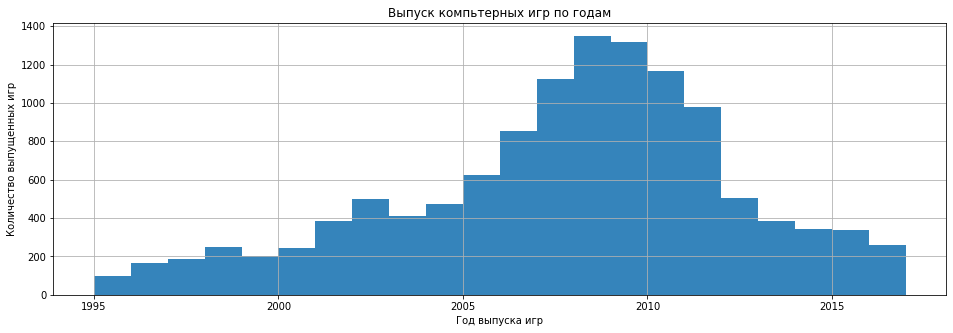

In [22]:
def make_bins(start, end, step):
    result = []
    for bin_elem in range(start, end + 1, step):
        result.append(bin_elem)
    return result

data_top_platforms = data.query('(platform in @top_platforms.index) and (year_of_release >= 1980)')

fig, ax = plt.subplots()
ax.set_title("Выпуск компьтерных игр по годам")
ax.set_xlabel('Год выпуска игр')
ax.set_ylabel('Количество выпущенных игр')

data_top_platforms['year_of_release'].hist(bins=make_bins(1995, 2017, 1), figsize=(16,5), alpha=0.9, ax=ax)

In [23]:
mean_dict = dict()
for platform in top_platforms.index.tolist():
    data_platform = data_top_platforms.query('platform == @platform')
    
    min_year = data_platform['year_of_release'].min()
    max_year = data_platform['year_of_release'].max()
    
    mean_dict[platform] = max_year - min_year

In [24]:
mean_dict

{'PS2': 11,
 'X360': 11,
 'PS3': 10,
 'Wii': 10,
 'DS': 28,
 'PS': 9,
 'PS4': 3,
 'GBA': 7,
 'PSP': 11,
 '3DS': 5}

In [25]:
mean = sum(mean_dict.values()) / len(mean_dict.values())
mean

10.5

In [26]:
del mean_dict['DS']
del mean_dict['PS4']

mean = sum(mean_dict.values()) / len(mean_dict.values())
mean

9.25

Let's take the average time of one platform for 10 years. But there are exceptions in the form of PC (working time is much higher than 31 years) and PS4 (working time is much shorter - 3 years).

In [27]:
data = data.query('(year_of_release >= 1995)')
data_actual = data.query('(year_of_release >= 2014)')

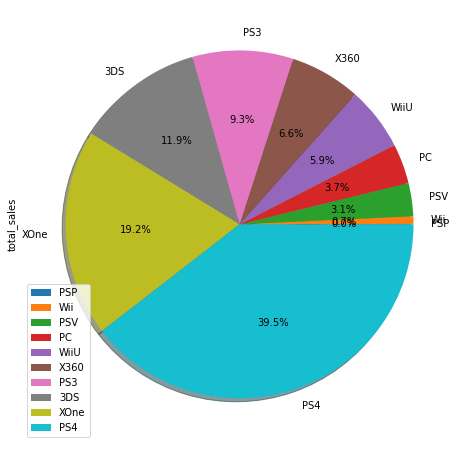

In [28]:
data_actual_1 = data.query('year_of_release >= 2014')
data_platform_pivot_1 = data_actual_1.groupby('platform')['total_sales'].agg('sum').sort_values(ascending = True)
data_platform_pivot_1.plot.pie(figsize=(8, 8), autopct='%1.1f%%',shadow = True)
plt.legend()
plt.show()

### Note
Since the average life of the platform is 10 years, it is worth analyzing the data for the last 10 years. But for other parameters, like genre, it will probably be necessary to go back to data over a longer period.

In [29]:
data_platform_pivot = data_actual.pivot_table(index=['platform', 'year_of_release'], values=['total_sales'], aggfunc=['sum'])
data_platform_pivot = data_platform_pivot.reset_index(level='year_of_release')
data_platform_pivot.columns = ['year', 'total_sales_sum']

data_platform_pivot_for_plot = data_platform_pivot.reset_index()
data_platform_pivot_for_plot = data_platform_pivot_for_plot.pivot(index='year', columns='platform', values='total_sales_sum')

Text(0, 0.5, 'Сумма продаж')

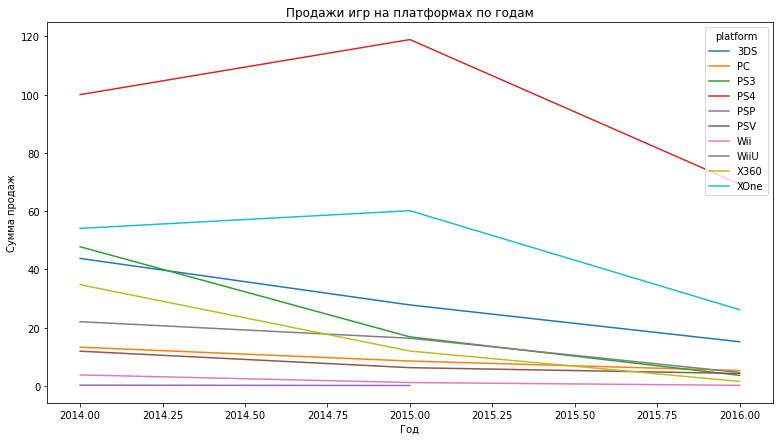

In [30]:
fig, ax = plt.subplots()
data_platform_pivot_for_plot.plot(figsize=(13,7), ax=ax)
ax.set_title('Продажи игр на платформах по годам')
ax.set_xlabel('Год')
ax.set_ylabel('Сумма продаж')

<AxesSubplot:title={'center':'Распределение продаж по платформам'}, xlabel='Платформа', ylabel='Продажи'>

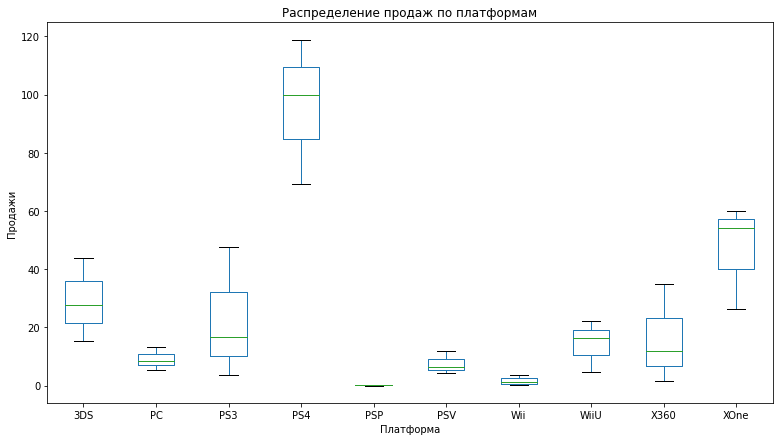

In [31]:
data_platform_pivot_for_plot.fillna(0, inplace=True)

fig, ax = plt.subplots(1)
ax.set_title('Распределение продаж по платформам')
ax.set_xlabel('Платформа')
ax.set_ylabel('Продажи')
data_platform_pivot_for_plot.plot(kind='box', figsize=(13,7), ax=ax)

### intermediate output
Most of the platforms are not working at the moment. 3 platforms demonstrate the largest volume of sales - PS4, Xbox One, PC.
The data for 2016 is incomplete, but the PS4 leads the way with huge growth. The XBox one is also showing growth, with the PC in demand as the platform has been in operation for 20 years, although it is currently not a leader in terms of sales.

Platforms are very different from each other, the higher the popularity of the platform, the higher the scatter is. PS2, PS3, PS4 and X360 platforms stand out in particular. Along with this, the Nintendo DS lags behind, but not by much. Differences are observed, both in terms of sales in general, and in terms of average values.

The values ​​of PC are not entirely clear, since the spread of values ​​is not large, but the platform has been operating for more than 20 years.

Text(0, 0.5, 'Сумма продаж')

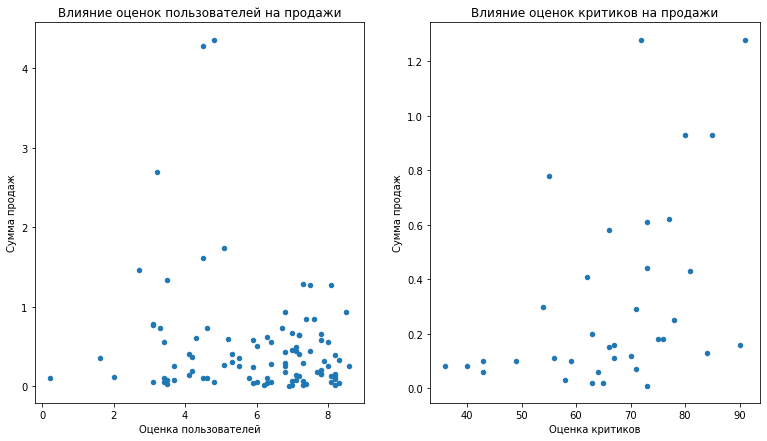

In [32]:
data_ps3 = data_actual.query('platform == "PS3"')
fig, ax = plt.subplots(1, 2)
data_ps3.plot(x='user_score', y='total_sales', kind='scatter', ax=ax[0], figsize=(13,7))
data_ps3.plot(x='critic_score', y='total_sales', kind='scatter', ax=ax[1], figsize=(13,7))

ax[0].set_title('Влияние оценок пользователей на продажи')
ax[0].set_xlabel('Оценка пользователей')
ax[0].set_ylabel('Сумма продаж')
ax[1].set_title('Влияние оценок критиков на продажи')
ax[1].set_xlabel('Оценка критиков')
ax[1].set_ylabel('Сумма продаж')

In [33]:
data_actual['total_sales'] = data_actual['total_sales'].astype('float')
data_actual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 31 to 16443
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                1689 non-null   object 
 1   platform            1689 non-null   object 
 2   year_of_release     1689 non-null   object 
 3   genre               1689 non-null   object 
 4   na_sales            1689 non-null   object 
 5   eu_sales            1689 non-null   object 
 6   jp_sales            1689 non-null   object 
 7   other_sales         1689 non-null   object 
 8   critic_score        718 non-null    float64
 9   user_score          888 non-null    float64
 10  rating              1689 non-null   object 
 11  critis_score_start  718 non-null    float64
 12  user_score_start    888 non-null    float64
 13  total_sales         1689 non-null   float64
dtypes: float64(5), object(9)
memory usage: 197.9+ KB


/tmp/ipykernel_53/3821703310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_actual['total_sales'] = data_actual['total_sales'].astype('float')


In [34]:
data_slice = data_actual.query('platform in @top_platforms.index')[['platform', 'user_score', 'critic_score', 'total_sales']]

data_result = pd.DataFrame(data=[], index=['user_score', 'critic_score'], columns=[])
for platform in data['platform'].unique():
    data_slice_platform = data_slice.query('platform == @platform')
    user_score_corr = data_slice_platform['user_score'].corr(data_slice_platform['total_sales'])
    critic_score_corr = data_slice_platform['critic_score'].corr(data_slice_platform['total_sales'])
    data_result[platform] = [user_score_corr, critic_score_corr]

data_result.dropna(axis='columns', inplace=True)
data_result

,X360,PS3,PS4,3DS
user_score,-0.138445,-0.166761,-0.040132,0.215193
critic_score,0.525723,0.446575,0.402661,0.314117


<AxesSubplot:title={'center':'Влияение оценки критиков и пользователей на продажи'}, xlabel='Оценки', ylabel='Величина корреляции'>

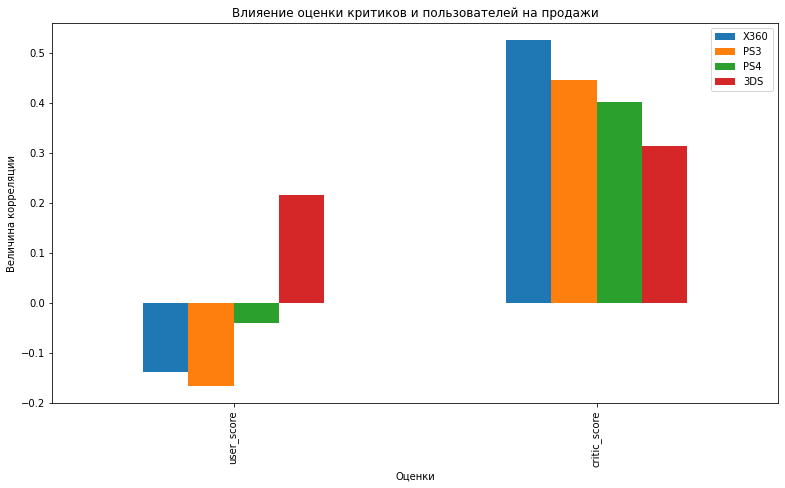

In [35]:
fig, ax = plt.subplots(1)
ax.set_title('Влияение оценки критиков и пользователей на продажи')
ax.set_xlabel('Оценки')
ax.set_ylabel('Величина корреляции')
data_result.plot(kind='bar', figsize=(13,7), ax=ax)

### intermediate output

Critics' rating has a stronger effect on sales than user rating. At the same time, the rating of critics above 7 begins to have a tangible impact, in the range from 4 to 7 the influence is not so strong.

There are games that sell well regardless of user ratings. This is probably due to the fact that user ratings are not always objective.

In [36]:
data_actual['genre'].value_counts()

Action          619
Role-Playing    221
Adventure       185
Sports          161
Shooter         128
Misc            113
Racing           69
Fighting         60
Simulation       44
Platform         38
Strategy         37
Puzzle           14
Name: genre, dtype: int64

<AxesSubplot:title={'center':'Топ количества игр по жанрам'}, xlabel='Жанр игры', ylabel='Количество выпущенных игр'>

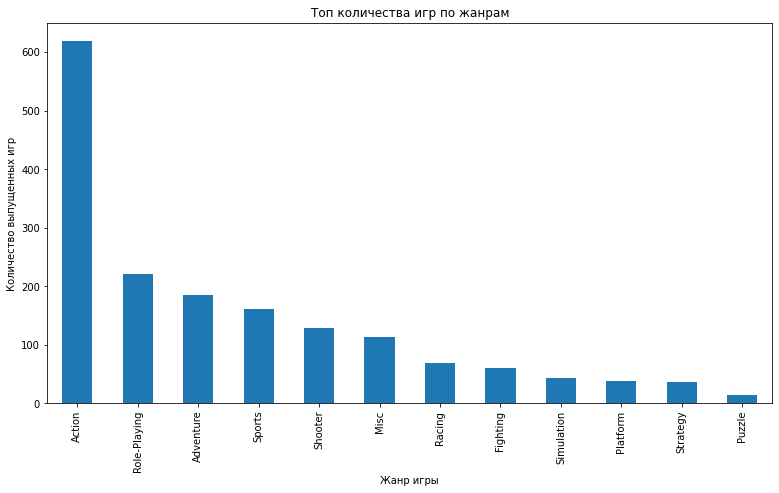

In [37]:
fig, ax = plt.subplots(1)
ax.set_title('Топ количества игр по жанрам')
ax.set_xlabel('Жанр игры')
ax.set_ylabel('Количество выпущенных игр')
data_actual['genre'].value_counts().plot(kind='bar', figsize=(13,7), ax=ax)

In [38]:
top_genre_sales = data_actual.groupby('genre')['total_sales'].mean().nlargest(15)
top_genre_sales

genre
Shooter         1.335469
Sports          0.680000
Platform        0.476053
Fighting        0.470333
Role-Playing    0.459005
Racing          0.398841
Misc            0.332301
Action          0.322068
Simulation      0.298409
Puzzle          0.157857
Strategy        0.107027
Adventure       0.094865
Name: total_sales, dtype: float64

### intermediate output

1. The most profitable genres are shooters and sports games
2. Despite the fact that Action takes the first place in terms of the number of games, they do not occupy a leading position in terms of sales.
3. Adventure games, of which there are many, have some of the worst sales figures.
4. RPGs are in the sweet spot along with mixed genre games, although they are released in large numbers.

## User portrait of each region

Text(0, 0.5, 'Количество игр')

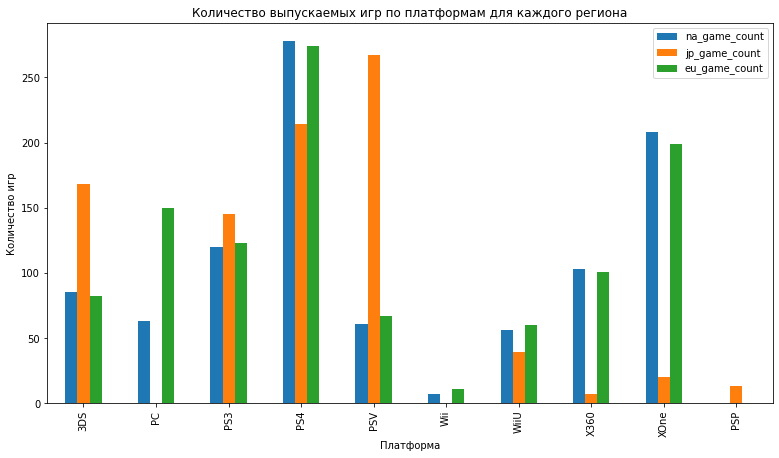

In [39]:
data_na = data_actual.query('na_sales > 0')
data_jp = data_actual.query('jp_sales > 0')
data_eu = data_actual.query('eu_sales > 0')

data_na_count = data_na.groupby('platform')['name'].count().to_frame()
data_na_count.columns = ['na_game_count']
data_jp_count = data_jp.groupby('platform')['name'].count().to_frame()
data_jp_count.columns = ['jp_game_count']
data_eu_count = data_eu.groupby('platform')['name'].count().to_frame()
data_eu_count.columns = ['eu_game_count']

data_for_bar = data_na_count.merge(data_jp_count, how='outer', on='platform')
data_for_bar = data_for_bar.merge(data_eu_count, how='outer', on='platform')

del data_na_count
del data_jp_count
del data_eu_count

fig, ax = plt.subplots(1)
data_for_bar.plot(kind='bar', figsize=(13,7), ax=ax)
ax.set_title('Количество выпускаемых игр по платформам для каждого региона')
ax.set_xlabel('Платформа')
ax.set_ylabel('Количество игр')

Text(0, 0.5, 'Сумма продаж')

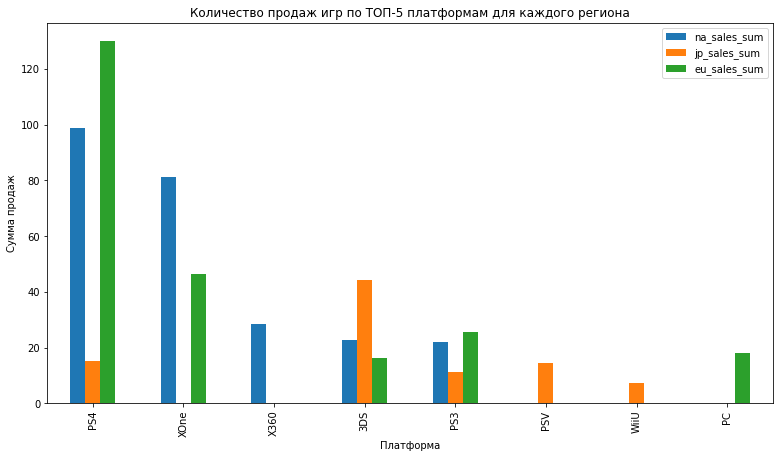

In [40]:
def source_data_for_bar(groupby_value, type_value, func_value, top_count):
    regions = ['na', 'jp', 'eu']
    for region in regions:
        if (type_value == 'sales'):
            column_name = region + '_' + type_value
        else:
            column_name = type_value
        
        if region == 'na':
            data_na_temp = data_na.groupby(groupby_value)[column_name]
        elif region == 'jp':
            data_jp_temp = data_jp.groupby(groupby_value)[column_name]
        else:
            data_eu_temp = data_eu.groupby(groupby_value)[column_name]
    
    if (func_value == 'sum'):
        data_na_temp = data_na_temp.sum().nlargest(top_count).to_frame()
        data_jp_temp = data_jp_temp.sum().nlargest(top_count).to_frame()
        data_eu_temp = data_eu_temp.sum().nlargest(top_count).to_frame()
    else:
        data_na_temp = data_na_temp.count().nlargest(top_count).to_frame()
        data_jp_temp = data_jp_temp.count().nlargest(top_count).to_frame()
        data_eu_temp = data_eu_temp.count().nlargest(top_count).to_frame()
        
    data_na_temp.columns = ['na_' + type_value + '_' + func_value]
    data_jp_temp.columns = ['jp_' + type_value + '_' + func_value]
    data_eu_temp.columns = ['eu_' + type_value + '_' + func_value]
    
    result = data_na_temp.merge(data_jp_temp, how='outer', on=groupby_value)
    result = result.merge(data_eu_temp, how='outer', on=groupby_value)
    
    return result

data_for_bar = source_data_for_bar('platform', 'sales', 'sum', 5)

fig, ax = plt.subplots(1)
data_for_bar.plot(kind='bar', figsize=(13,7), ax=ax)
ax.set_title('Количество продаж игр по ТОП-5 платформам для каждого региона')
ax.set_xlabel('Платформа')
ax.set_ylabel('Сумма продаж')

### Intermediate conclusions
1. North America has the highest sales and Japan the lowest.
2. In North America, the X360 leads in terms of sales, in Japan, Nintendo, and in Europe, PS3.
3. In Japan, the top sales are slightly different from Europe and America - they include 3DS and PSP, which are not in the top of other regions.
4. In the USA, it got into the top PS2, despite the presence of PS3. And in Europe - PS4. It can be considered more progressive (after all, the platform is new) and conservative (there are no specific platforms in the top).
5. At the same time, Nintendo and PS3 lead in terms of purchased games in all regions. PS3 turns out to be the most versatile platform for all regions

Text(0, 0.5, 'Сумма продаж')

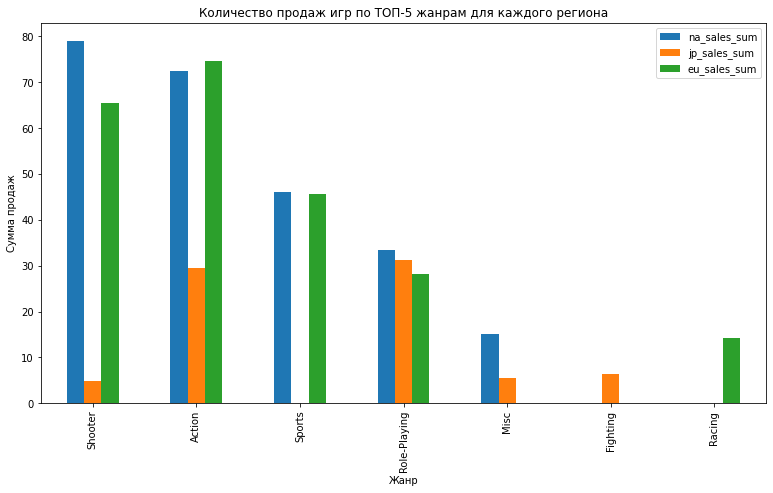

In [41]:
data_for_bar = source_data_for_bar('genre', 'sales', 'sum', 5)

fig, ax = plt.subplots(1)
data_for_bar.plot(kind='bar', figsize=(13,7), ax=ax)
ax.set_title('Количество продаж игр по ТОП-5 жанрам для каждого региона')
ax.set_xlabel('Жанр')
ax.set_ylabel('Сумма продаж')

Text(0, 0.5, 'Количество выпущенных игр')

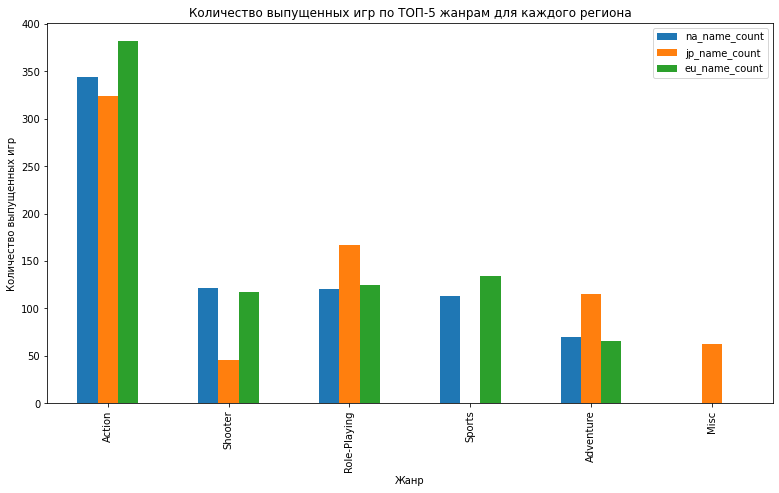

In [42]:
data_for_bar = source_data_for_bar('genre', 'name', 'count', 5)

fig, ax = plt.subplots(1)
data_for_bar.plot(kind='bar', figsize=(13,7), ax=ax)
ax.set_title('Количество выпущенных игр по ТОП-5 жанрам для каждого региона')
ax.set_xlabel('Жанр')
ax.set_ylabel('Количество выпущенных игр')

### Intermediate conclusions

1. Preferences in America and Europe are generally similar.
2. In general, the most popular genre for any region can be considered Action
3. Sports games and shooters are in 2nd and 3rd places, but shooters are not so popular in Japan.
4. Role-playing games are the most popular in Japan.
5. Also Japan is more popular than America and Europe adventure games, which are in 3rd place.

In [43]:
data_actual['na_sales'] = data['na_sales'].astype('float')
data_actual['jp_sales'] = data['jp_sales'].astype('float')
data_actual['eu_sales'] = data['eu_sales'].astype('float')
data_actual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 31 to 16443
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                1689 non-null   object 
 1   platform            1689 non-null   object 
 2   year_of_release     1689 non-null   object 
 3   genre               1689 non-null   object 
 4   na_sales            1689 non-null   float64
 5   eu_sales            1689 non-null   float64
 6   jp_sales            1689 non-null   float64
 7   other_sales         1689 non-null   object 
 8   critic_score        718 non-null    float64
 9   user_score          888 non-null    float64
 10  rating              1689 non-null   object 
 11  critis_score_start  718 non-null    float64
 12  user_score_start    888 non-null    float64
 13  total_sales         1689 non-null   float64
dtypes: float64(8), object(6)
memory usage: 197.9+ KB


/tmp/ipykernel_53/2686550207.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_actual['na_sales'] = data['na_sales'].astype('float')
/tmp/ipykernel_53/2686550207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_actual['jp_sales'] = data['jp_sales'].astype('float')
/tmp/ipykernel_53/2686550207.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [44]:
data_actual_rating = data_actual[['na_sales', 'jp_sales', 'eu_sales', 'rating']]

<function matplotlib.pyplot.show(close=None, block=None)>

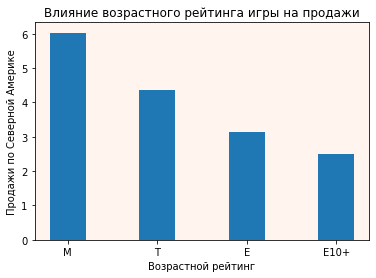

In [45]:
x1 = data_actual_rating['rating'] 
y1 = data_actual_rating['na_sales']
fig, ax = plt.subplots()
ax.bar(x1, y1, width = 0.4)
ax.set_title('Влияние возрастного рейтинга игры на продажи')
ax.set_xlabel('Возрастной рейтинг')
ax.set_ylabel('Продажи по Северной Америке')
ax.set_facecolor('seashell')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

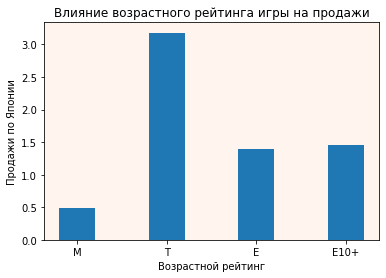

In [46]:
x2 = data_actual_rating['rating'] 
y2 = data_actual_rating['jp_sales']
fig, ax = plt.subplots()
ax.bar(x2, y2, width = 0.4)
ax.set_title('Влияние возрастного рейтинга игры на продажи')
ax.set_xlabel('Возрастной рейтинг')
ax.set_ylabel('Продажи по Японии')
ax.set_facecolor('seashell')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

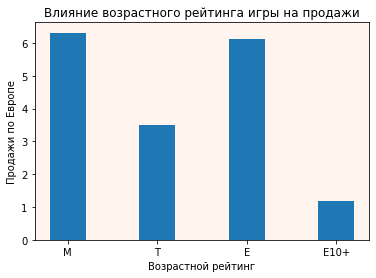

In [47]:
x3 = data_actual_rating['rating'] 
y3 = data_actual_rating['eu_sales']
fig, ax = plt.subplots()
ax.bar(x3, y3, width = 0.4)
ax.set_title('Влияние возрастного рейтинга игры на продажи')
ax.set_xlabel('Возрастной рейтинг')
ax.set_ylabel('Продажи по Европе')
ax.set_facecolor('seashell')
plt.show

### intermediate output
In North America and Europe, games with a higher rating sell slightly better. But this correlation is not as strong as for Japan. In Japan, games with a more "childish" rating sell better.

## Hypothesis testing

### The average user ratings of the Xbox One and PC platforms are the same

Hypothesis H0: The average user ratings of the Xbox One and PC platforms are the same

Hypothesis H1: The average user ratings of the Xbox One and PC platforms are different

In [48]:
H0 = 'Не можем отвергнуть гипотизу - средние пользовательские рейтинги платформ Xbox One и PC одинаковы'
H1 = 'Отвергаем нулевую гипотезу, средние пользовательские рейтинги платформ Xbox One и PC различаются'

alpha = 0.05 

data_xbox_one = data_actual.query('platform == "XOne"')
data_pc = data_actual.query('platform == "PC"')

<AxesSubplot:>

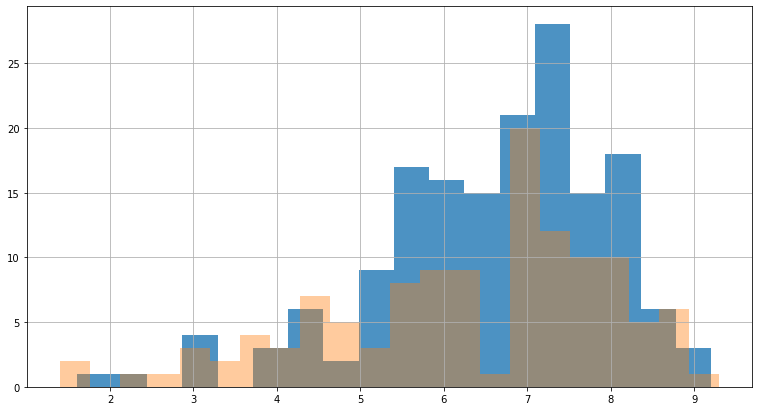

In [49]:
data_xbox_one['user_score'].hist(bins=18, alpha=0.8, figsize=(13,7))
data_pc['user_score'].hist(bins=22, alpha=0.4, figsize=(13,7))

In [50]:
print('PC count =', data_pc['user_score'].count())
print('Xbox count =', data_xbox_one['user_score'].count())

PC count = 122
Xbox count = 165


Имеются кол-ные данные в двух независимых выборках, которые распределены нормально (хоть и немного смещены влево). Выборки не сверхмалы, не содержат явных выбросов. Поэтому Т-критерий Стьюдента можно использовать. 

In [51]:
results = st.ttest_ind(data_xbox_one['user_score'], data_pc['user_score'], equal_var = False)

if results.pvalue < alpha:
    print(H1)
else:
    print(H0)

Не можем отвергнуть гипотизу - средние пользовательские рейтинги платформ Xbox One и PC одинаковы


In [52]:
print('XBOX user score mean = ', data_xbox_one['user_score'].mean())
print('PC user score mean = ', data_pc['user_score'].mean())

XBOX user score mean =  6.594545459024834
PC user score mean =  6.298360683878914


### Conclusion on the first hypothesis
The null hypothesis is confirmed, the average user ratings of the Xbox One and PC platforms are the same (differences do not exceed the specified alpha criterion of 5%).

### Average user ratings for the Action and Sports genres are different

Hypothesis H0: Average user ratings for Action and Sports are the same

Hypothesis H1: The average user ratings of the Action and Sports genres are different

In [53]:
H0 = 'Не можем отвергнуть гипотизу - cредние пользовательские рейтинги жанров Action и Sports одинаковы'
H1 = 'Отвергаем нулевую гипотезу, cредние пользовательские рейтинги жанров Action и Sports различаются'

data_action = data_actual.query('genre == "Action"')
data_sports = data_actual.query('genre == "Sports"')

<AxesSubplot:>

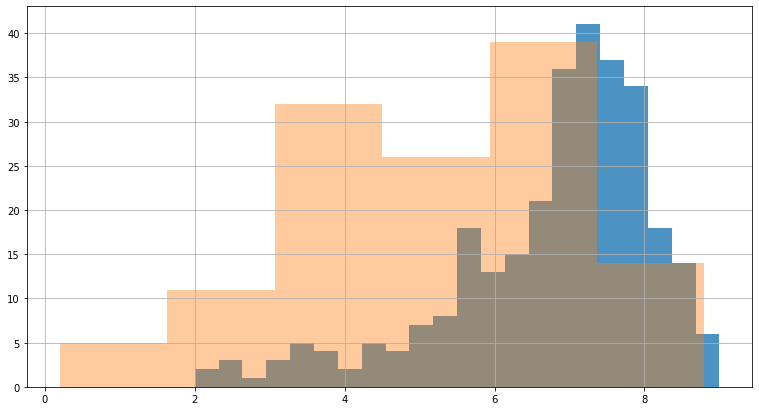

In [54]:
data_action['user_score'].hist(bins=22, alpha=0.8, figsize=(13,7))
data_sports['user_score'].hist(bins=6, alpha=0.4, figsize=(13,7))

In [55]:
print('Action count =', data_action['user_score'].count())
print('Sport count =', data_sports['user_score'].count())

Action count = 297
Sport count = 127


There are counts of data in two independent samples that are normally distributed (albeit slightly skewed to the left). The samples are not ultra-small and do not contain explicit outliers. Therefore, Student's T-test can be used.

In [56]:
results = st.ttest_ind(data_action['user_score'], data_sports['user_score'], equal_var = False)

if results.pvalue < alpha:
    print(H1)
else:
    print(H0)

Не можем отвергнуть гипотизу - cредние пользовательские рейтинги жанров Action и Sports одинаковы


In [57]:
print('Action user score mean = ', data_action['user_score'].mean())
print('Sports user score mean = ', data_sports['user_score'].mean())

Action user score mean =  6.760606079390555
Sports user score mean =  5.225196847882796


### Conclusion on the second hypothesis
The null hypothesis was confirmed. Differences in the average rating of Action and Sport games do not differ (no more significant than the given alpha criterion of 5%).

## Study Conclusions
Data was obtained on sales of computer games in different regions. They took the following steps:
1. Data exploration
2. They were prepared, the missing values ​​were filled in, duplicates were removed and TBD was replaced with NAN so as not to delete 14% of the data.
3. Conducted research data:

Intermediate conclusions:
    
    The average life of the platform is 10 years, so data from 2006 was used for the study.
    There are three platforms that you should pay special attention to - PS4, Xbox One, PC.
    Critics' ratings have a greater impact on sales than user ratings.
    The most profitable genres are shooters and sports games.
    Separately, the preferences of each of the three regions represented (North America, Europe and Japan) were studied.
    The most profitable region is North America, while Japan brings in the least money
    At the same time, each region has its own leaders among platforms in terms of sales (In North America, this is X360; in Japan, Nintendo DS; in Europe, PS3)
    The most versatile platform for everyone is PS3
    Preferences for game genres in Europe and America are similar, while in Japan the popularity of role-playing and adventure games is higher and lower for shooters.
    The most popular genre for each region can be considered Action.
    In Japan, games with less adult ratings are preferred, while in Europe and America, games with adult ratings are slightly more preferred.

4. Hypotheses were tested:
    
    The average user ratings of the Xbox One and PC platforms do not differ, as well as the average user ratings of the Action and Sports genres.

# Recommendations for planning an advertising campaign
The purpose of the study was to identify patterns that affect the success of games, which will be used in the future when planning advertising campaigns.

Based on research:

1. Pay attention to shooter games and sports games. It is also worth highlighting the Action genre, as the most universal for all regions.
2. The North American market is the most profitable, where they spend more money on games.
3. At the same time, the preferences of residents of North America and Europe are similar, so advertising campaigns may be the same for the markets.
4. Japan is a specific market with special preferences and lower sales income. Probably worth reducing the advertising budget in this direction.
5. Among the platforms, the PS4 should be the most emphasized, as it is showing good growth and is relatively new. In addition, its predecessors PS2 and PS3 showed excellent financial results and leadership.
6. In the North American market, it is worth focusing on two platforms at once - XOne and PS4.
7. The remaining platforms bring less income, or their active period of work ends.

# Additional rating output
<div class="alert alert-info">
In North America, games rated M (Mature) sell best. In Europe, the biggest spend on games with M ("Mature") and rating E ("Men"). In Japan, the situation is different, and T-rated (Teen) games sell better.